# Setup

## Import necessary packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from cycler import cycler
from statsmodels.tsa.seasonal import STL

In [2]:
plt.rcParams['axes.prop_cycle'] = cycler(color=['k'])  # 'k' represents black

In [3]:
plt.rcParams.keys()

KeysView(RcParams({'_internal.classic_mode': False,
          'agg.path.chunksize': 0,
          'animation.bitrate': -1,
          'animation.codec': 'h264',
          'animation.convert_args': ['-layers', 'OptimizePlus'],
          'animation.convert_path': 'convert',
          'animation.embed_limit': 20.0,
          'animation.ffmpeg_args': [],
          'animation.ffmpeg_path': 'ffmpeg',
          'animation.frame_format': 'png',
          'animation.html': 'none',
          'animation.writer': 'ffmpeg',
          'axes.autolimit_mode': 'data',
          'axes.axisbelow': 'line',
          'axes.edgecolor': 'black',
          'axes.facecolor': 'white',
          'axes.formatter.limits': [-5, 6],
          'axes.formatter.min_exponent': 0,
          'axes.formatter.offset_threshold': 4,
          'axes.formatter.use_locale': False,
          'axes.formatter.use_mathtext': False,
          'axes.formatter.useoffset': True,
          'axes.grid': False,
          'axes.grid.axis': 'b

## Import example dataset

This is a simulated dataset that mimics aggregated daily active users for a product such as an application.<br>
timestamp: primary key that depects 1 day per row.<br>
daily_active_users: sum of daily active users group by timestamp

In [4]:
df = pd.read_csv('product_usage_data.csv')
df.head()

,timestamp,daily_active_users
0,1/1/2024,1107
1,1/2/2024,1113
2,1/3/2024,1143
3,1/4/2024,1140
4,1/5/2024,1136


In [5]:
df['timestamp'] = pd.to_datetime(df['timestamp'])

In [6]:
df.head()

,timestamp,daily_active_users
0,2024-01-01,1107
1,2024-01-02,1113
2,2024-01-03,1143
3,2024-01-04,1140
4,2024-01-05,1136


In [7]:
dau = pd.Series(data=df['daily_active_users'].values, index=df['timestamp'])

<Axes: xlabel='timestamp'>

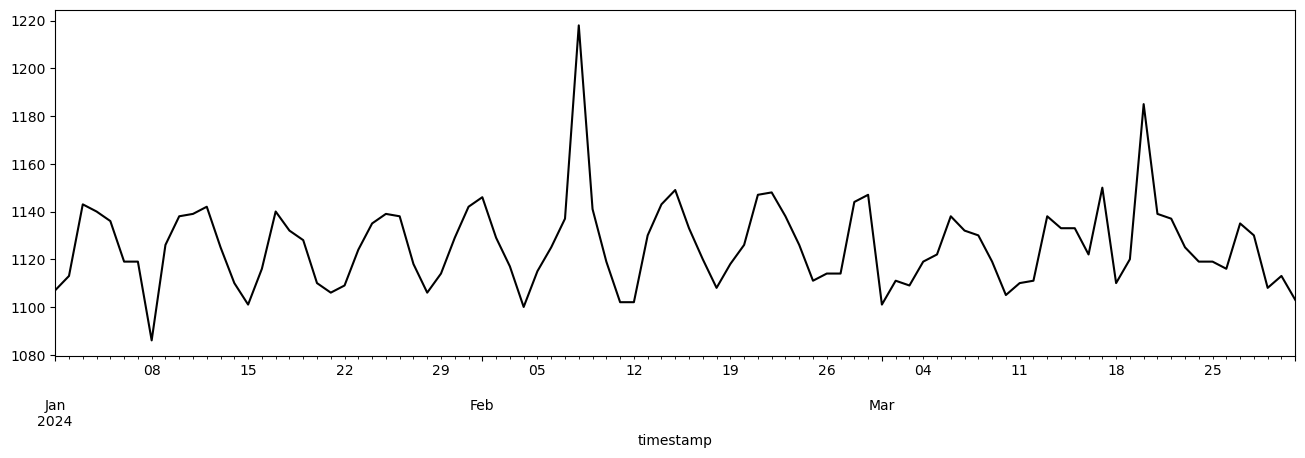

In [8]:
dau.plot(figsize=(16,4.5))

In [9]:
dau.describe()

count      91.000000
mean     1125.703297
std        18.362700
min      1086.000000
25%      1113.000000
50%      1125.000000
75%      1138.000000
max      1218.000000
dtype: float64

## Run Seasonal Trend Decomposition (STL)

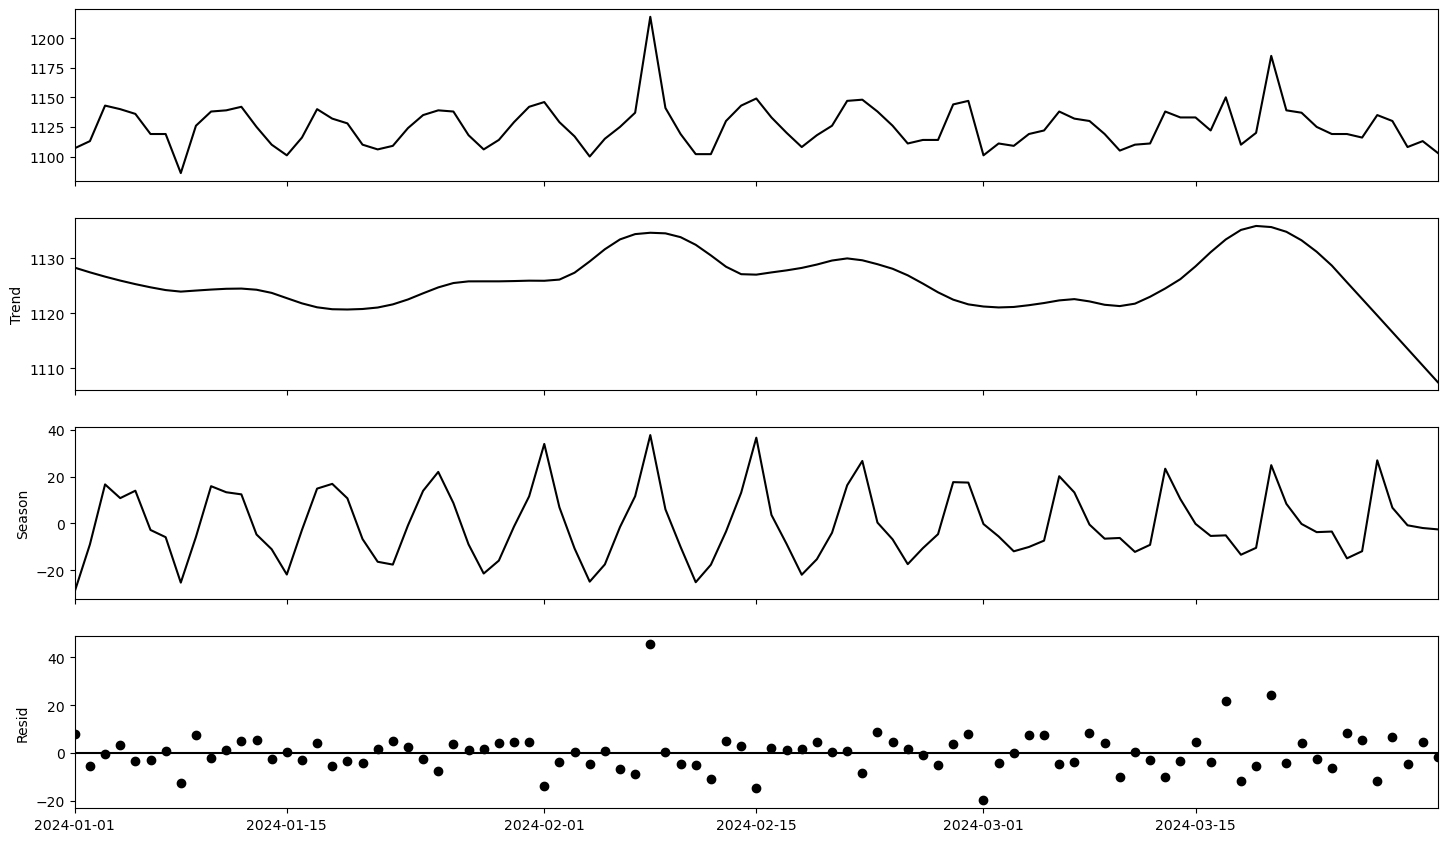

In [10]:
stl = STL(dau, period=7)  # weekly seasonality
res = stl.fit()

# Plot residuals
fig = res.plot()
fig.set_size_inches((16, 9))

<Axes: title={'center': 'Residuals'}, xlabel='timestamp'>

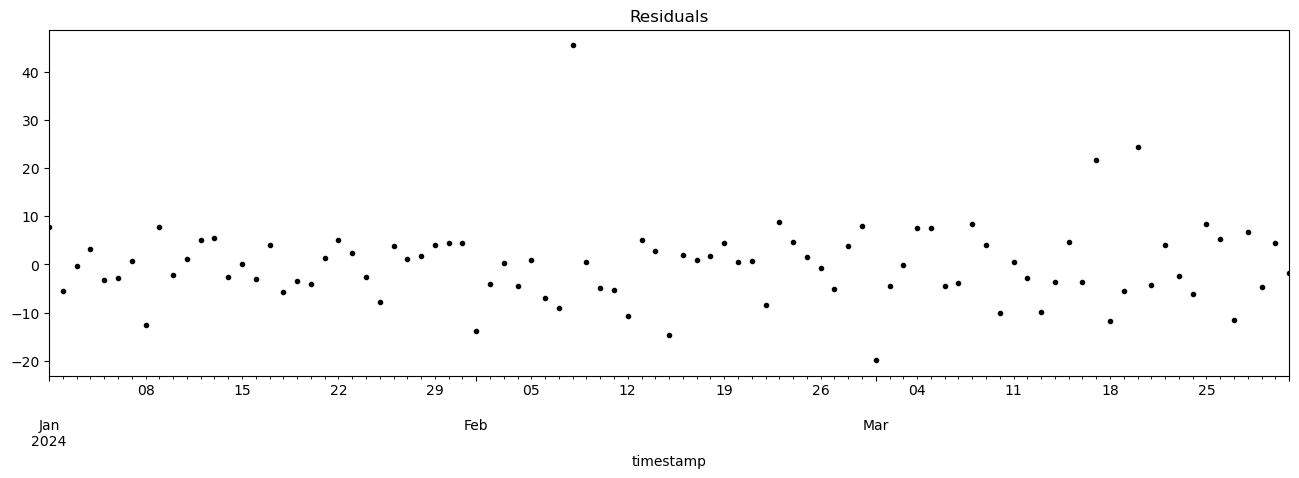

In [11]:
res.resid.plot(marker='.', linestyle='none', figsize=(16,4.5), title='Residuals')

## Identify anomalies based on trend and residuals

I am using 3 different confidence intervals (90%, 95%, 99.7%) to determine severity of anomalies. These correspond to 1, 2, and 3 standard deviations respectively.

In [12]:
trend_iv_l_minor = pd.Series(data=res.trend.values-np.mean(res.trend)-np.std(res.resid), index=res.trend.index)
trend_iv_u_minor = pd.Series(data=res.trend.values-np.mean(res.trend)+np.std(res.resid), index=res.trend.index)\

trend_iv_l_major = pd.Series(data=res.trend.values-np.mean(res.trend)-2*np.std(res.resid), index=res.trend.index)
trend_iv_u_major = pd.Series(data=res.trend.values-np.mean(res.trend)+2*np.std(res.resid), index=res.trend.index)

trend_iv_l_severe = pd.Series(data=res.trend.values-np.mean(res.trend)-3*np.std(res.resid), index=res.trend.index)
trend_iv_u_severe = pd.Series(data=res.trend.values-np.mean(res.trend)+3*np.std(res.resid), index=res.trend.index)

In [13]:
minor_anom = np.where((res.resid < trend_iv_l_minor) | (res.resid > trend_iv_u_minor), res.resid, np.nan)
major_anom = np.where((res.resid < trend_iv_l_major) | (res.resid > trend_iv_u_major), res.resid, np.nan)
severe_anom = np.where((res.resid < trend_iv_l_severe) | (res.resid > trend_iv_u_severe), res.resid, np.nan)

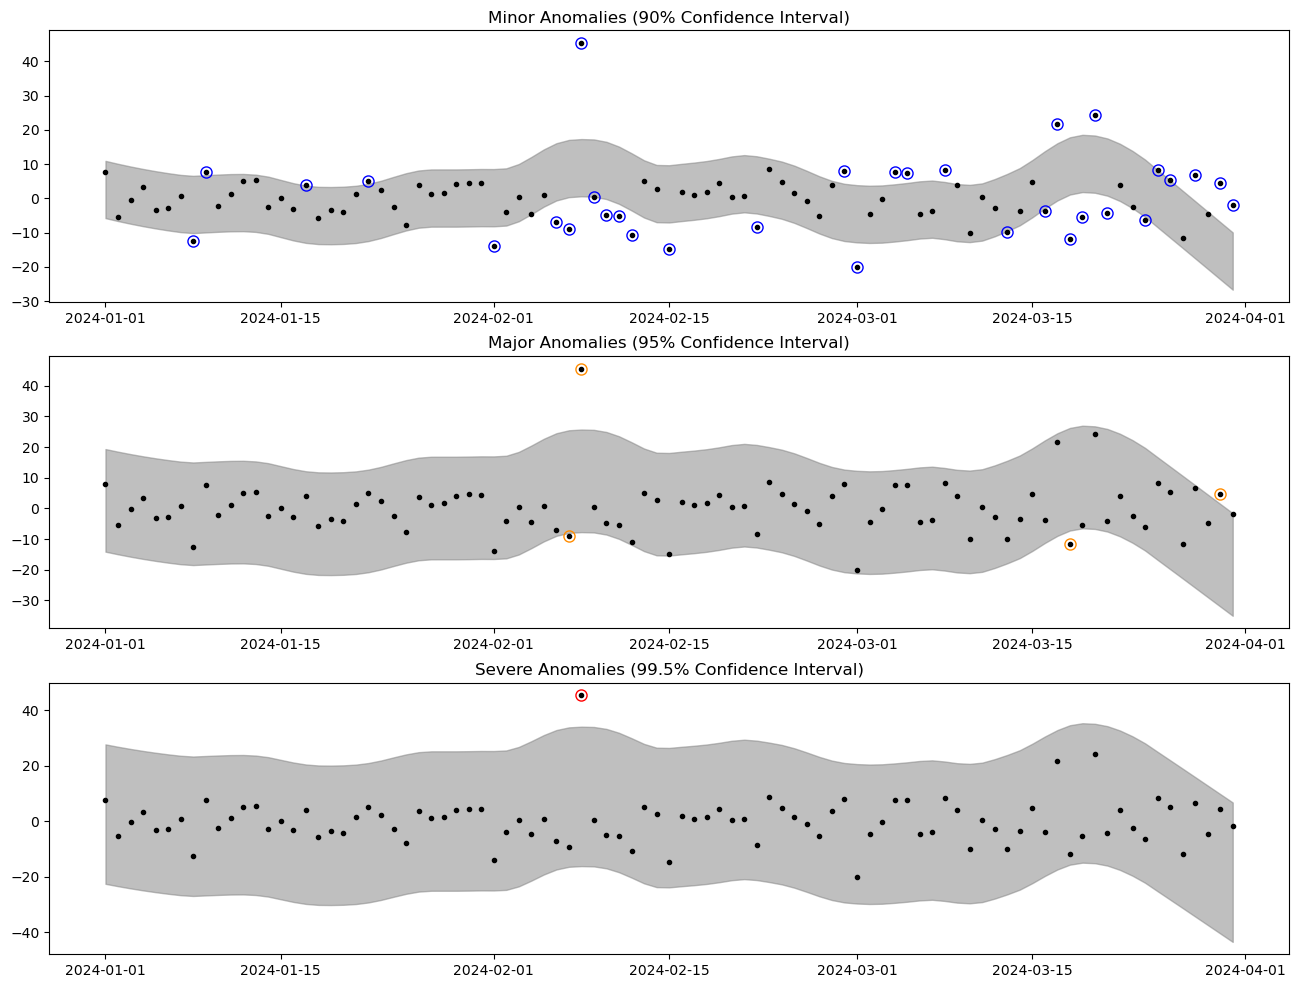

In [14]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, figsize=(16, 12))
ax1.plot(res.resid, marker='.', linestyle='none', label='Residuals')
ax1.plot(pd.Series(minor_anom, res.resid.index), marker='o', linestyle='none', label='Residuals', color='blue', fillstyle='none', markersize=8)
ax1.set_title('Minor Anomalies (90% Confidence Interval)')
ax1.fill_between(res.resid.index, trend_iv_l_minor, trend_iv_u_minor, color='grey', alpha=0.5, label='confidence interval')

ax2.plot(res.resid, marker='.', linestyle='none', label='Residuals')
ax2.plot(pd.Series(major_anom, res.resid.index), marker='o', linestyle='none', label='Residuals',  color='darkorange', fillstyle='none', markersize=8)
ax2.set_title('Major Anomalies (95% Confidence Interval)')
ax2.fill_between(res.resid.index, trend_iv_l_major, trend_iv_u_major, color='grey', alpha=0.5, label='confidence interval')

ax3.plot(res.resid, marker='.', linestyle='none', label='Residuals')
ax3.plot(pd.Series(severe_anom, res.resid.index), marker='o', linestyle='none', label='Residuals',  color='red', fillstyle='none', markersize=8)
ax3.set_title('Severe Anomalies (99.5% Confidence Interval)')
ax3.fill_between(res.resid.index, trend_iv_l_severe, trend_iv_u_severe, color='grey', alpha=0.5, label='confidence interval')

In [15]:
ax1.plot(minor_anom, marker='.', linestyle='none', label='Anomalies')

## Rerun Seasonal Trend Decomposition with anomaly detection

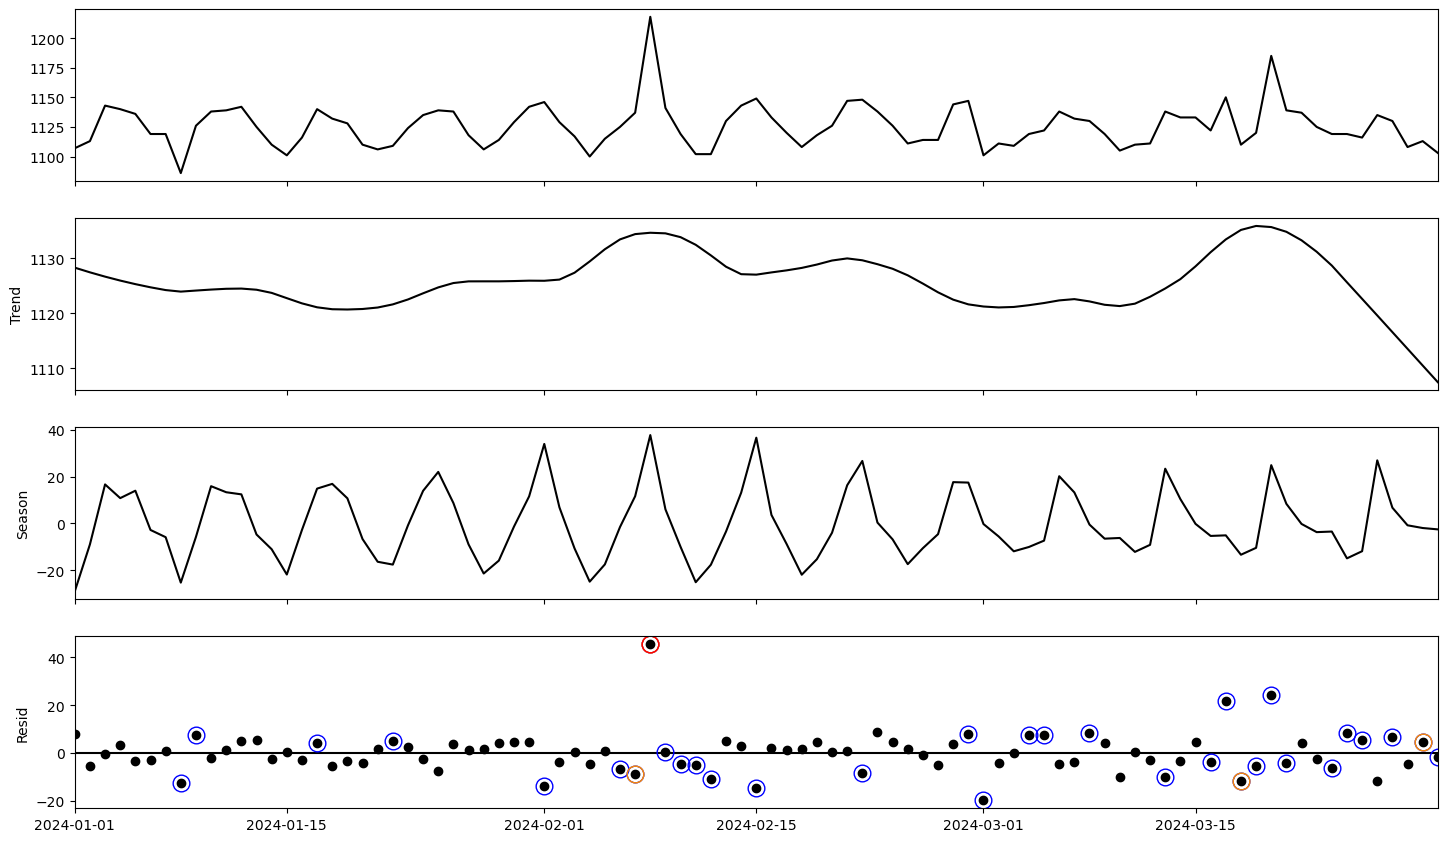

In [24]:
stl = STL(dau)
res = stl.fit()

# Plot residuals
fig = res.plot()
fig.set_size_inches((16, 9))

# Get the residuals axes (it's the last one in the STL plot)
data_ax = fig.get_axes()[0]
resid_ax = fig.get_axes()[-1]

# Highlight anomalies in the residuals plot
resid_ax.plot(res.resid.index, minor_anom, 'o', color='b', fillstyle='none', markersize=12)
resid_ax.plot(res.resid.index, major_anom, 'o', color='darkorange', fillstyle='none', markersize=12)
resid_ax.plot(res.resid.index, severe_anom, 'o', color='r', fillstyle='none', markersize=12)

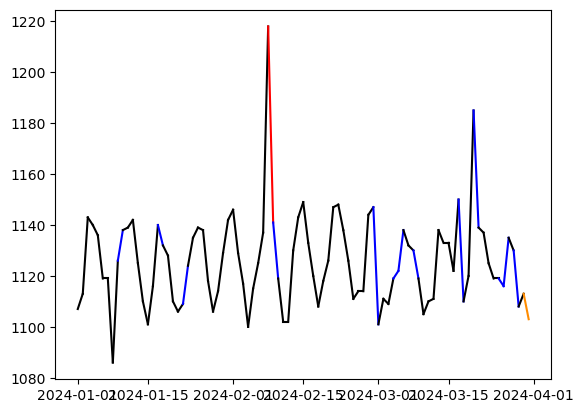

In [27]:
# Highlight anomalies in observed data
for i in range(len(res.observed)):
    if severe_anom[i] >= 0:
        color = 'r'
    elif major_anom[i] >= 0:
        color = 'darkorange'
    elif minor_anom[i] >= 0:
        color = 'b'
    else:  # no anomaly
        color = 'k'
    plt.plot(res.observed.index[i:i+2], res.observed[i:i+2], color=color)